### Simple input ATRLIF model with integer values only

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
#sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Use included models directory
#models_dir=None

# Use external models directory (containing ncProcessModels for Loihi)
models_dir='/homes/jlubo/brian2lava-models/models'

# Use external processes library (for Lava-Loihi/Loihi 2 hardware)
lava_proc_dir = "/homes/jlubo/brian2lava-models/lava_proc"

# Set device, choosing CPU with fixed-point representation, but switching off F2F conversion
set_device('lava', mode='preset', hardware='CPU', num_repr='fixed', use_f2f=False, models_dir=models_dir, lava_proc_dir=lava_proc_dir)

# Set device, choosing Brian's runtime device
#set_device('runtime')
#prefs.codegen.target = 'numpy'
#prefs.codegen.string_expression_target = 'numpy'

BrianLogger.log_level_debug()

WARNING    The name of one (or more) models defined in the given model directory '/homes/jlubo/brian2lava-models/models' already exists in Brian2Lava's standard model library. Note that user-defined models will always override standard models. If you do not want this to happen, rename your model folder(s). [brian2lava.preset_mode.model_loader]


In [4]:
# Import ATRLIF model
from brian2lava.preset_mode.model_loader import atrlif

In [5]:
# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 1 * second #0.5*ms

In [6]:
print(atrlif.equations, type(atrlif.equations))
print(atrlif.conditions)

dj/dt = -j/tau_j : V/s
dr/dt = -r/tau_r : V
dtheta/dt = (-(theta-theta_0) + theta_0)/tau_theta : V
dv/dt = -v/tau_v + j + bias : V <class 'brian2.equations.equations.Equations'>
{'th': 'v-r > theta', 'rs': ['r = r + 2*theta', 'theta = theta + theta_step']}


Model name (name of the Lava process)                                           
--------------------------------------------------------------------------------
atrlif                                                                          


Description                                                                     
--------------------------------------------------------------------------------
Adaptive-Threshold and -Reset Leaky Integrate-and-Fire neuron                   


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


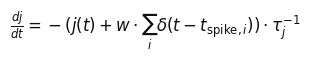

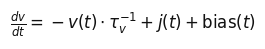

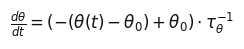

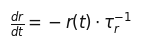

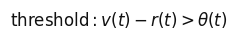

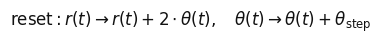



Brian 2 equations                                                               
--------------------------------------------------------------------------------
dj/dt = -j/tau_j : volt/second                                                  
dv/dt = -v/tau_v + j + bias : volt                                              
dtheta/dt = (-(theta-theta_0) + theta_0)/tau_theta : volt                       
dr/dt = -r/tau_r : volt                                                         


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v-r > theta                                                                
rs : ['r = r + 2*theta', 'theta = theta + theta_step']                          


Refractory period                                                               
--------------------------------------------------------------------------------
<not supported>


Vari

In [7]:
atrlif.show()

In [8]:
## Define conversion factor
cf = 1000

# Define parameters (same as for the example in our internal neuron models repo)
N = 3
bias = 0.003 * cf * mV/ms
tau_j = 1 * cf * ms
tau_v = 2.048 * cf * ms #10 * cf * ms # delta_v = dt/tau_v*2^12
tau_theta = 2.048 * cf * ms #10 * cf * ms
tau_r = 4.096 * cf * ms #5 * cf * ms
theta_0 = 5 * cf * mV
theta_step = 3.75 * cf * mV

# Transcribe reset conditions (convert list to multiline string)
reset_cond = "\n".join(atrlif.conditions["rs"])

# Add a spike generator group
S = SpikeGeneratorGroup(N, [0, 0], [2, 6]*second) 

# Add a neuron group (which receives a background input)
P = NeuronGroup(N, atrlif.equations, threshold=atrlif.conditions["th"], reset=reset_cond, method='euler')
P.j = "0 * cf * mV/ms"
P.v = "0 * cf * mV"
P.theta = theta_0
P.r = "0 * cf * mV"

# Add another neuron group (which does not receive a background input)
Q = NeuronGroup(N, atrlif.equations, threshold=atrlif.conditions["th"], reset=reset_cond, method='euler')
#Q.j = "0.1*mV/ms"
Q.v = "0 * cf * mV"
Q.theta = theta_0
Q.r = "0 * cf * mV"

# Add synapses
syn = Synapses(S, Q, model = 'w : volt/second', on_pre='j_post += w')
syn.connect(i=[0], j=[0,1,2])
syn.w = 50 * cf * mV/second

DEBUG      Creating synapses from group 'spikegeneratorgroup' to group 'neurongroup_1', using pre-defined arrays) [brian2.synapses.synapses]


In [9]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [10]:
# Add monitor for spikes
#sm = SpikeMonitor(P)
spmP = SpikeMonitor(P, variables='v', record=True)
spmQ = SpikeMonitor(Q, variables='v', record=True)

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPj = StateMonitor(P, variables='j', record=True)
stmPtheta = StateMonitor(P, variables='theta', record=True)
stmPr = StateMonitor(P, variables='r', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQj = StateMonitor(Q, variables='j', record=True)
stmQtheta = StateMonitor(Q, variables='theta', record=True)
stmQr = StateMonitor(Q, variables='r', record=True)

In [11]:
# Run simulation
run(21 * second)

DEBUG      Updated MagicNetwork to include 21 objects with names statemonitor, neurongroup_1, neurongroup_1_spike_thresholder, statemonitor_5, synapses_pre, spikemonitor_1, statemonitor_2, spikemonitor, statemonitor_1, neurongroup_1_spike_resetter, neurongroup_1_stateupdater, neurongroup_stateupdater, statemonitor_3, statemonitor_6, neurongroup_spike_resetter, statemonitor_7, spikegeneratorgroup, neurongroup, neurongroup_spike_thresholder, statemonitor_4, synapses [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 21 objects: neurongroup, neurongroup_1, statemonitor, statemonitor_1, statemonitor_2, statemonitor_3, statemonitor_4, statemonitor_5, statemonitor_6, statemonitor_7, synapses, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikegeneratorgroup, spikemonitor, spikemonitor_1, synapses_pre, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]

PyATRLIFModelFixed initialized


DEBUG      Setting weights in process 'synapses' [brian2.devices.lava]
DEBUG      -- weights_scaled(3) = [[50  0  0]
 [50  0  0]
 [50  0  0]] [brian2.devices.lava]
DEBUG      Running process: neurongroup, <class 'lava_workspace.CPU_preset_neurongroup.ATRLIF'> [brian2.devices.lava]


PyATRLIFModelFixed initialized


DEBUG      Successfully run simulation [brian2.devices.lava]
INFO       Retrieving monitor values [brian2.devices.lava]
INFO       Successfully retrieved monitor values [brian2.devices.lava]
INFO       Updating Brian variables [brian2.devices.lava]
INFO       Successfully updated Brian variables [brian2.devices.lava]


In [12]:
#stm2.variables['v'].get_value()
print("------- P -------")
print(f"P.v = {P.v}")
print(f"P.j = {P.j}")
print(f"stmPv.t =\n{stmPv.t}")
print(f"stmPv.v =\n{stmPv.v[0]}")
print(f"stmPr.r =\n{stmPr.r[0]}")
print(f"stmPtheta.theta =\n{stmPtheta.theta[0]}")
print("------- Q -------")
print(f"Q.v = {Q.v}")
print(f"Q.j = {Q.j}")
print(f"stmQv.v =\n{stmQv.v[0]}")
print(f"stmQr.r =\n{stmQr.r[0]}")
print(f"stmQtheta.theta =\n{stmQtheta.theta[0]}")

------- P -------
P.v = <neurongroup.v: array([5., 5., 5.]) * volt>
P.j = <neurongroup.j: array([0., 0., 0.]) * volt / second>
stmPv.t =
<statemonitor.t: array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20.]) * second>
stmPv.v =
[0. 3. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5.] V
stmPr.r =
[ 0.  0.  0. 10.  7.  5.  3.  2.  1. 10.  7.  5.  3.  2.  1. 10.  7.  5.
  3.  2.  1.] V
stmPtheta.theta =
[5. 5. 5. 9. 7. 6. 5. 5. 5. 9. 7. 6. 5. 5. 5. 9. 7. 6. 5. 5. 5.] V
------- Q -------
Q.v = <neurongroup_1.v: array([6., 6., 6.]) * volt>
Q.j = <neurongroup_1.j: array([0., 0., 0.]) * volt / second>
stmQv.v =
[ 0.  3.  4.  5. 55. 31. 18. 12. 59. 33. 19. 12.  9.  7.  6.  6.  6.  6.
  6.  6.  6.] V
stmQr.r =
[ 0.  0.  0. 10. 21. 31. 23. 17. 22. 30. 22. 16. 12.  9.  6.  4.  3.  2.
 11.  8.  6.] V
stmQtheta.theta =
[ 5.  5.  5.  9. 11. 12.  8.  6.  9. 11.  8.  6.  5.  5.  5.  5.  5.  5.
  9.  7.  6.] V


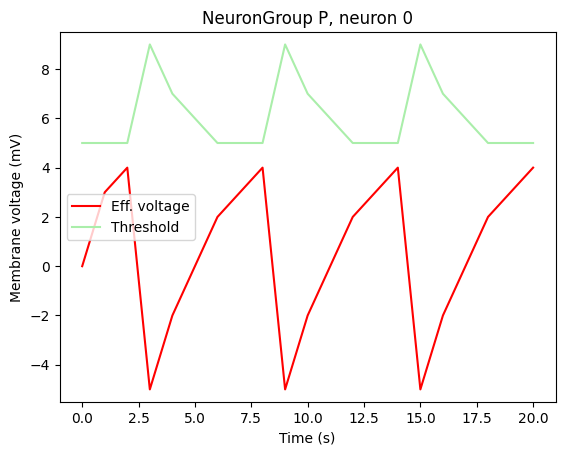

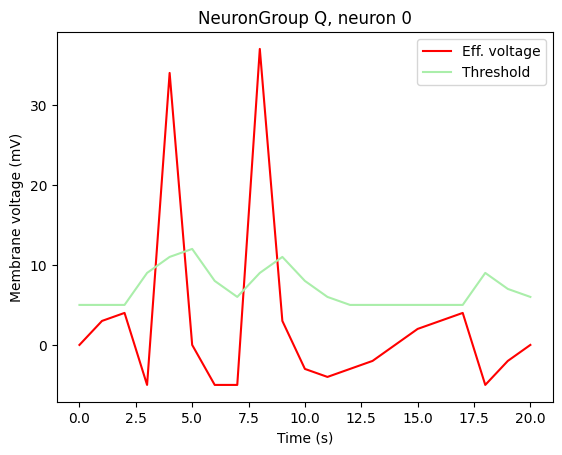

In [13]:
plt.plot(stmPv.t/second, (stmPv.v[0]-stmPr.r[0])/mV/cf, color="#ff0000", label='Eff. voltage')
plt.plot(stmPtheta.t/second, stmPtheta.theta[0]/mV/cf, color="#aaeeaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
ylim(-5.5, 9.5)
legend()
show()

plt.plot(stmQv.t/second, (stmQv.v[0]-stmQr.r[0])/mV/cf, color="#ff0000", label='Eff. voltage')
plt.plot(stmQtheta.t/second, stmQtheta.theta[0]/mV/cf, color="#aaeeaa", label='Threshold')
title('NeuronGroup Q, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
legend()
show()

In [14]:
print("NeuronGroup P:")
print("  ", len(spmP.i), "spikes occurred in total.")
print("  ", spmP.i)
print("  ", spmP.t)
print("  ", spmP.v)
print("NeuronGroup Q:") # TODO readout out `.i` and `.t` variables does not work here yet
print("  ", len(spmQ.i), "spikes occurred in total.")
print("  ", spmQ.i)
print("  ", spmQ.t)
print("  ", spmQ.v)

NeuronGroup P:
   12 spikes occurred in total.
   <spikemonitor.i: array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])>
   <spikemonitor.t: array([ 2.,  2.,  2.,  8.,  8.,  8., 14., 14., 14., 20., 20., 20.]) * second>
   <spikemonitor.v: array([4., 4., 4., 5., 5., 5., 5., 5., 5., 5., 5., 5.]) * volt>
NeuronGroup Q:
   18 spikes occurred in total.
   <spikemonitor_1.i: array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2])>
   <spikemonitor_1.t: array([ 2.,  2.,  2.,  3.,  3.,  3.,  4.,  4.,  4.,  7.,  7.,  7.,  8.,
        8.,  8., 17., 17., 17.]) * second>
   <spikemonitor_1.v: array([ 4.,  4.,  4.,  5.,  5.,  5., 55., 55., 55., 12., 12., 12., 59.,
       59., 59.,  6.,  6.,  6.]) * volt>
